# Estimation des Kernels

Nous allons calculer $\Phi_t^{ij}$ de manière itérative de la manière suivante.

1) On choisit un pas de discrétisation dt pour une quadrature trapézoidale (on verra plus tard pour une quadrature gaussienne).
2) On va avoir $\Phi_{s_m}^{ij} = g_{s_m}^{ij} - \sum_k \sum_l w_l g_{s_m -s_l}^{kl} \Phi_{s_l}^{ik}$
Comme $g$ et $\Phi$ sont nuls pour des temps négatifs (ou nul), on peut calculer ce tout de manière itérative de la manière suivante.
On calcule $\Phi_{s_1}^{ij} = g_{s_1}^{ij}$ pour $i,j = 1,...,4$
Puis on calcule $\Phi_{s_2}^{ij} = g_{s_2}^{ij} - \sum_k dt g_{s_2-s_1}^{kj} \Phi_{s_1}{ik}$. Et ainsi de suite
On obtient ainsi $\Phi$ pour $s_1, ..., s_m$, on peut interpoler (de manière plus précise qu'avec une interpolation linéaire) avec la formule.$\Phi_{t}^{ij} = g_{t}^{ij} - \sum_k \sum_l w_l g_{t -s_l}^{kl} \Phi_{s_l}^{ik}$.

Codons

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
dfN = pd.read_parquet('data/alljumptimesN_1000000.parquet')
dfT = pd.read_parquet('data/alljumptimesT_1000000.parquet')
dfCP = pd.read_parquet('data/countingprocess_1000000.parquet')
dfJT = pd.read_parquet('data/jumptimes_1000000.parquet')

In [7]:
def g_ij(s1, s2, T, dt) :
    
    e = np.zeros(int(T/dt))
    n_batch = 0
    i = 0
    i2 = 0
    batch_beginning = s2[i2]
    n_data = min(len(s1), len(s2))
    while ((i<n_data-1) and (i2<n_data - 1)) :
        while ((s1[i] <= batch_beginning) and (i<n_data-1)): #Recherche du saut de s1 suivant le saut de s2, on met un <= pour le cas s1 = s
            i+=1
        jumptime = s1[i] - batch_beginning
        if jumptime > T :
            #Recherche du batch_beginning
            while (s2[i2]<s1[i] and (i2<n_data - 1)) :
                i2+=1
            batch_beginning = s2[i2] 
            n_batch+=1
        else :
            e[int(jumptime/dt)]+=1
        i+=1
    e = e/n_batch
    Lambda = 1/s1.diff()[1:].mean()
    g = e/dt - Lambda
    return g

In [10]:
#Code des g_ij pour T = 100, dt = 0.5

T = 100 #Horizon d'estiamtion de g_t
dt = 0.5 #Pas de discrétisation de g_t
s1 = dfJT['0'].dropna()
s2 = dfJT['1'].dropna()
s3 = dfJT['2'].dropna()
s4 = dfJT['3'].dropna()
g = np.zeros((4,4,int(T/dt)))
for i in range(4) :
    for j in range(4) :
        g[i,j,:] =  g_ij(locals()[f"s{i+1}"], locals()[f"s{j+1}"], T, dt)

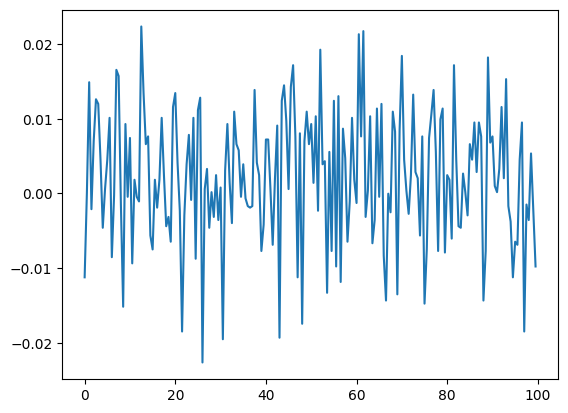

In [11]:
#Plot de g_t

x = np.arange(0,T, dt)
plt.plot(x, g[0,0,:] )
plt.show()

In [12]:
#Calcul de phi
time_steps = int(T/dt)
phi = np.copy(g) #On s'économise le premier terme de phi_t^ij = g_t^ij
for m in range(time_steps) :
    for i in range(4) :
        for j in range(4) :     
            for k in range(4) :
                for l in range(m) :
                    phi[i,j,m] -= dt*g[k,j,m-l]*phi[i,k,l]
                    

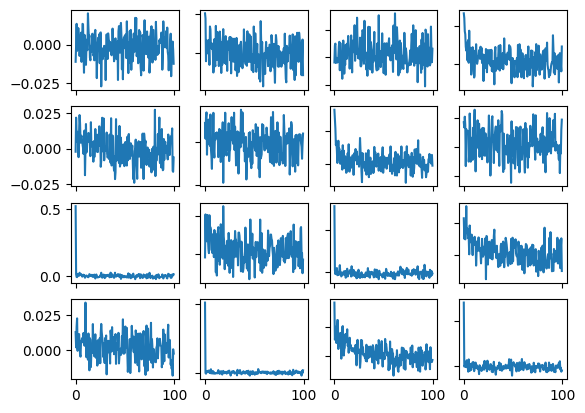

In [15]:
x = np.arange(0,T, dt)
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].plot(x, phi[i,j,:])

for ax in axs.flat:
    ax.label_outer()